--------------------------------------------------------------

## **Bayesian Deep Learning & Estimating Uncertainty**

--------------------------------------------------------------

Performances of Deep Neural Networks (DNNs) rely on the ability to progressively build and extract features from large data. Though these deep models are usually adaptive the performance depends on the data distribution. The robustness property is important in various applications such as computer vision tasks, eg. autonomous driving, because the outdoor environments may naturally vary. One thing at this point we would desire is to **know how likely the predictions are going to be correct, and this can be done by incorporating uncertainty estimation within the model**.

For this example, we have used real weather data [publicly available](https://www.kaggle.com/datasets/muthuj7/weather-dataset) and built simple linear and non-linear models to find not only the best models but also the corresponding uncertainty estimations.

Useful resources:
1. [Aleatoric and epistemic uncertainty in machine learning: an introduction to concepts and methods](https://link.springer.com/article/10.1007/s10994-021-05946-3). 
2. [What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?](https://arxiv.org/abs/1703.04977).
3. [Bayesian Deep Learning & Estimating Uncertainty](https://towardsdatascience.com/bayesian-deep-learning-estimating-uncertainty-9907f5208cc0)
4. [Aleatoric and Epistemic Uncertainty in Deep Learning
](https://towardsdatascience.com/aleatoric-and-epistemic-uncertainty-in-deep-learning-77e5c51f9423)
5. [Uncertainty Quantification](https://en.wikipedia.org/wiki/Uncertainty_quantification)

One of the easiest to ways to get started with different types of uncertainties is to think about reducible and irreducible uncertainties.

**_Aleatoric Uncertainty_:** *captures noise inherent in the observations*. This could be for example sensor noise or motion noise, resulting in uncertainty **which cannot be reduced** even if more data were to be collected. 

**_Epistemic Uncertainty_:** *accounts for uncertainty in the model parameters*. This uncertainty captures insufficiency or ignorance/negligence about certain aspects in our collected data. This uncertainty **can be explained away given enough data**, and is often referred to as model uncertainty.

**These uncertainties are formalized as probability distributions over either the model parameters (for Epistemic Uncertainty), or model outputs (for Aleatoric Uncertainty).** Epistemic uncertainty is modeled by placing a prior distribution over a model’s weights, and then trying to capture how much these weights vary given some data. Aleatoric uncertainty on the other hand is modeled by placing a distribution over the output of the model. 

--------------------------------------------------------------

## **Bayesian Neural Networks (BNNs) - Capturing Uncertainty**

--------------------------------------------------------------

**To capture epistemic uncertainty** in a neural network $(NN)$ we put a prior distribution over its weights, for example a Gaussian prior distribution: $W ∼ \mathcal{N} (0, I)$.

Such a model is referred to as a *Bayesian Neural Network (BNN)*. Bayesian neural networks **replace the deterministic network’s weight parameters with distributions over these parameters, and instead of optimising the network weights directly, we average over all possible weights** (referred to as marginalization). Denoting the random output of the BNN as $f^{W}(x)$, we define the model likelihood $p\left(y|f^{W}(x)\right)$. Given a dataset $X = \{x_1, ..., x_N\},\, Y=\{y_1,\, \ldots , y_N\}$, Bayesian inference
is used to compute the posterior over the weights $p(W|X, Y)$. This posterior captures the set of plausible model parameters, given the data. For regression tasks we often define our likelihood as a Gaussian with mean given by the model
output: $p(y|f^{W}(x)) = \mathcal{N} \left(f^W(x), \sigma^2\right)$, with an observation noise scalar parameter $\sigma$.

BNNs are are easy to formulate, but difficult to perform inference in. This is because the marginal probability $p(Y|X)$ required to evaluate the posterior $p(W|X, Y)= \frac{p(Y|X,W) \cdot p(W)}{p(Y|X)}$ cannot be evaluated analytically. However, different methods exist to capture epistemic uncertainty (model parameter uncertainty), by approximating the distribution $p(W|X, Y)$.

---

**To capture aleatoric uncertainty** in regression, we would have to tune the observation noise parameter $σ$. **Homoscedastic regression** assumes constant observation noise $\sigma$ for every input point $x$. **Heteroscedastic regression**, on the other hand, assumes that observation noise can vary with input $x$. Heteroscedastic models are useful in cases where parts of the observation space might have higher noise levels than others.

------------------------------------------------------
------------------------------------------------------

## **_Dataset_**
As mentioned earlier, the weather dataset is available openly for public use [here](https://www.kaggle.com/datasets/muthuj7/weather-dataset).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

tfpl = tfp.layers
tfd = tfp.distributions

In [ ]:

from google.colab import drive
drive.mount('/content/drive/')

path_to_file = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive/


In [ ]:
weather_df = pd.read_csv(path_to_file + 'Weather_Data.csv', sep=',', parse_dates=['Formatted Date'])
weather_df.head(3)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00+02:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00+02:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00+02:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.


In [ ]:
print(weather_df.columns)
print ('dataframe shape: ', weather_df.shape)

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')
dataframe shape:  (96453, 12)


In [ ]:
print (weather_df['Formatted Date'].max(), weather_df['Formatted Date'].min())

2016-12-31 23:00:00+01:00 2006-01-01 00:00:00+01:00


In [ ]:
weather_df['datetime'] = pd.to_datetime(weather_df['Formatted Date'], utc=True)
weather_df = weather_df.set_index('datetime')
weather_df.head(3)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
datetime,,,,,,,,,,,,
2006-03-31 22:00:00+00:00,2006-04-01 00:00:00+02:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
2006-03-31 23:00:00+00:00,2006-04-01 01:00:00+02:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2006-04-01 00:00:00+00:00,2006-04-01 02:00:00+02:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.


In [ ]:
weather_df.drop(['Formatted Date'], axis=1, inplace=True)
weather_df.head(3)

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
datetime,,,,,,,,,,,
2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.


In [ ]:
weather_df_selected = weather_df[['Temperature (C)', 'Humidity']]
weather_df_selected.head(3)

,Temperature (C),Humidity
datetime,,
2006-03-31 22:00:00+00:00,9.472222,0.89
2006-03-31 23:00:00+00:00,9.355556,0.86
2006-04-01 00:00:00+00:00,9.377778,0.89


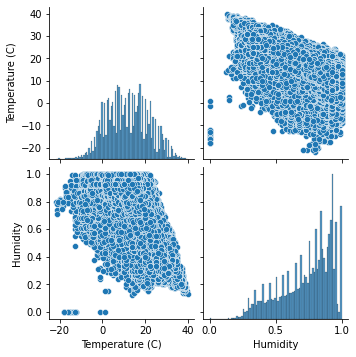

In [ ]:
from sys import path_importer_cache
weather_df_selected = weather_df_selected.loc[:,~weather_df_selected.columns.duplicated()]
weather_df_selected.reset_index(inplace=True)

pairplot = sns.pairplot(weather_df_selected, )
# pairplot.savefig(path_to_file + '/TensorFlow_AdvancedSp./TensorFlow_Prob/weather_pair_plot.png', dpi=200)

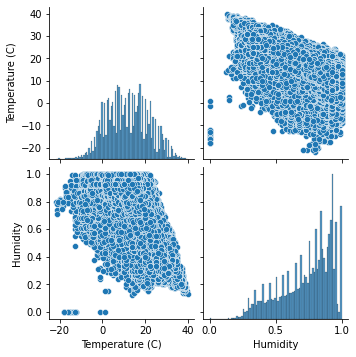

In [ ]:
pairplot = sns.pairplot(weather_df_selected, )
# pairplot.savefig(path_to_file + '/TensorFlow_AdvancedSp./TensorFlow_Prob/weather_pair_plot.png', dpi=200)

In [ ]:
weather_df_selected = weather_df_selected.set_index('datetime')
weather_df_selected.head(3)

,Temperature (C),Humidity
datetime,,
2006-03-31 22:00:00+00:00,9.472222,0.89
2006-03-31 23:00:00+00:00,9.355556,0.86
2006-04-01 00:00:00+00:00,9.377778,0.89


In [ ]:
weather_df_selected.shape

(96453, 2)

Temperature and Humidity have some linear relationships, let's try to model it!  

In [ ]:
resampled_humidity_3d = weather_df_selected["Humidity"].resample("3D").mean()
resampled_temperature_3d = weather_df_selected["Temperature (C)"].resample("3D").mean()

print ('length after resampling: ', len(resampled_temperature_3d))

length after resampling:  1340


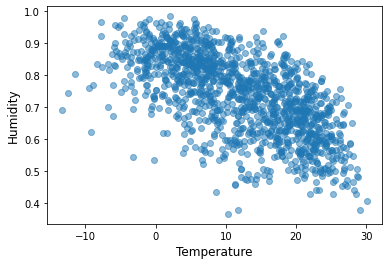

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.scatter(resampled_temperature_3d, resampled_humidity_3d, alpha=0.5)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Humidity', fontsize=12)
plt.show()

In [ ]:
print (resampled_humidity_3d.shape, resampled_temperature_3d.shape)
print (type(resampled_humidity_3d))

(1340,) (1340,)
<class 'pandas.core.series.Series'>


In [ ]:
X_s = resampled_temperature_3d.to_numpy()
Y_s = resampled_humidity_3d.to_numpy()

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_s, Y_s, test_size=0.2, random_state=30)
print ('X train shape: ', X_train.shape)
print ('X test shape: ', X_test.shape)
print ('Y test shape: ', y_test.shape)

X train shape:  (1072,)
X test shape:  (268,)
Y test shape:  (268,)


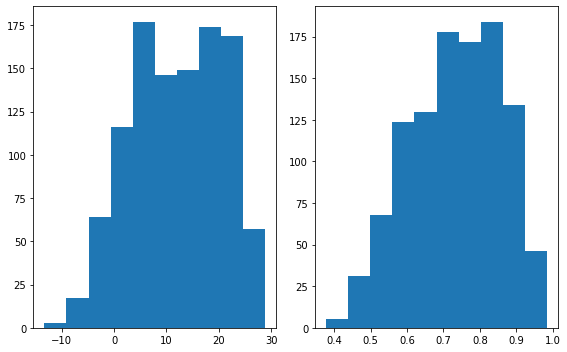

In [ ]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(121)
plt.hist(X_train)
fig.add_subplot(122)
plt.hist(y_train)
plt.tight_layout()
plt.show()

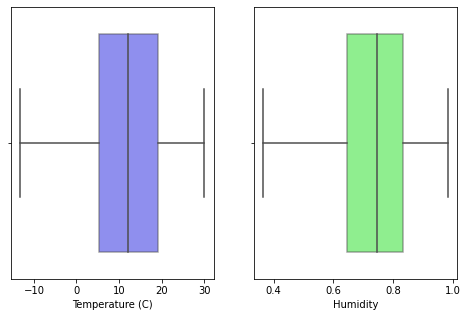

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

sns.boxplot(ax=axes[0], x=resampled_temperature_3d, color='blue', boxprops=dict(alpha=.5) )
sns.boxplot(ax=axes[1], x=resampled_humidity_3d, color='lime', boxprops=dict(alpha=.5))

In [ ]:
### at this point it is better to standardize the temperature because the humidity is always within 0, 1

from sklearn.preprocessing import StandardScaler

X_train_re = X_train.reshape(-1, 1)
X_test_re = X_test.reshape(-1, 1)

print ('shapes before and after: ', X_train.shape, X_train_re.shape)

scaler = StandardScaler().fit(X_train_re)

X_train_scaled = scaler.transform(X_train_re)
X_test_scaled = scaler.transform(X_test_re)

print ('check min max after transformation: ', min(X_train_scaled), max(X_train_scaled))

shapes before and after:  (1072,) (1072, 1)
check min max after transformation:  [-2.94731033] [1.94578062]


## **Uncertainties Inherent in the Data (Aleatoric Uncertainty)**

### **_Deterministic Linear Regression_**

In [ ]:
det_lin_model = tf.keras.models.Sequential([tf.keras.layers.Dense(units=1, input_shape=(1,) ) ]) # 1 weight, 1 bias ; y = mx + c 
det_lin_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.005))
det_lin_model.summary()
det_lin_model.fit(X_train_scaled, y_train, epochs=200, verbose=False)

pred_y = det_lin_model.predict(X_train_scaled)

# pred_y

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


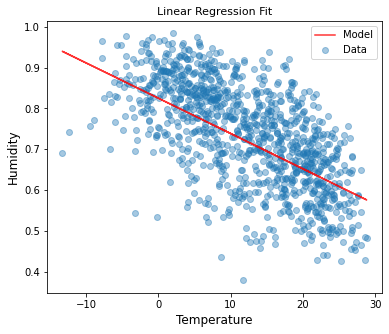

In [ ]:
fig = plt.figure(figsize=(6, 5))
plt.scatter(X_train, y_train, alpha=0.4, label='Data')
plt.plot(X_train, pred_y, color='red', alpha=0.8, label='Model')
plt.legend()
plt.title('Linear Regression Fit', fontsize=11)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Humidity', fontsize=12)
# plt.savefig(path_to_file + '/TensorFlow_AdvancedSp./TensorFlow_Prob/Temp_Humid_LinReg.png', dpi=200)
plt.show()

### **_Probabilistic Regression_**

---

#### Linear _Probabilistic Model_


First we check effect of **trainable mean but constant variance of 1**. 

The model is predicting one target variable (Humidity). We expect our model to learn the mean of the labels (here it's Humidity). 

`DistrbutionLambda` layer takes the previous layer output (i.e. `Dense` layer) and returns a normal distribution (object) with mean defined by $t$. So the normal distribution is trainable. 

In [ ]:
prob_lin_model = tf.keras.models.Sequential([tf.keras.layers.Dense(units=1, input_shape=(1, )), 
                                             tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1)))]) 

# t is the output from the previous dense layer, 
# output from the dense layer was used to parametrize the mean of a normal distribution.
# normal distribution is trainable  
prob_lin_model.summary()

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
 distribution_lambda (Distri  ((None, 1),              0         
 butionLambda)                (None, 1))                         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def nll(y_true, y_pred):
  return -y_pred.log_prob(y_true)

prob_lin_model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005))
prob_lin_model.fit(X_train_scaled, y_train, epochs=200, verbose=False)

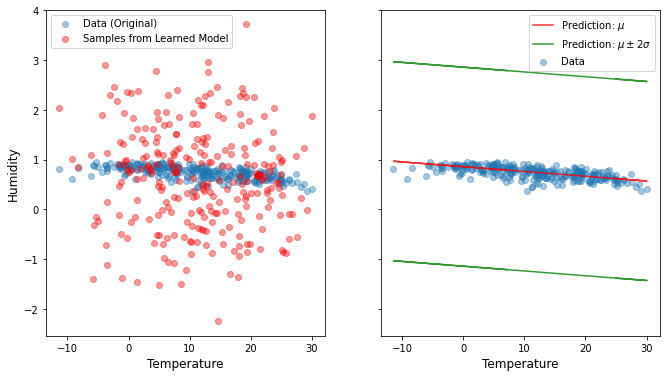

In [ ]:
y_model = prob_lin_model(X_test_scaled)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), sharey=True)
ax1.scatter(X_test, y_test, alpha=0.4, label='Data (Original)')
ax1.scatter(X_test, y_sample, alpha=0.4, color='red', label='Samples from Learned Model')
ax1.set_xlabel('Temperature', fontsize=12)
ax1.set_ylabel('Humidity', fontsize=12)
ax1.legend()
ax2.scatter(X_test, y_test, alpha=0.4, label='Data')
ax2.plot(X_test, y_hat, color='red', alpha=0.8, label='Prediction: $\mu$')
ax2.plot(X_test, y_hat_m2sd, color='green', alpha=0.8, label='Prediction: $\mu \pm 2 \sigma$')
ax2.plot(X_test, y_hat_p2sd, color='green', alpha=0.8)
ax2.set_xlabel('Temperature', fontsize=12)
ax2.legend()
# plt.savefig(path_to_file + '/TensorFlow_AdvancedSp./TensorFlow_Prob/Temp_Humid_LinReg_Mean.png', dpi=200)
plt.show()

```
y_model = prob_lin_model(X_test_scaled)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
```
This part is particularly interesting because we can use `sample`, `mean` or `stddev` from the model to either sample from the distribution, get the mean/stddev etc. This is in accordance with our modeling assumption that the probabilistic model actually represents the data generating process.   


Problem with the previous model is that we only learned the mean of the normal distribution, but the scale i.e. standard deviation is fixed at 1. We need to learn that too... Let's do that! 

Also remember deterministic linear regression gives us only the point estimate but no info on aleatoric uncertainty. But now we have a full predictive distribution with mean and std. I am using Independent Distribution which  is used to treat a collection of independent, not-necessarily-identical (aka a batch of) distributions as a single distribution. More examples on [Independent Distribution here.](https://www.tensorflow.org/probability/examples/Understanding_TensorFlow_Distributions_Shapes#the_independent_distribution)

In [ ]:
prob_lin_model_1 = tf.keras.models.Sequential([tf.keras.layers.Dense(units=2, input_shape=(1, )), 
                                             tfpl.DistributionLambda(lambda t: tfd.Independent(
                                                 tfd.Normal(loc=t[...,:1], scale=tf.math.softplus(t[..., 1:]))))
                                             ])

## loc=t[..., :1] ensures that first parameter is used to learn the loc
## since std cannot be negative we use the softplus. # smooth approximation of relu

prob_lin_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 4         
                                                                 
 distribution_lambda_1 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


Better way to write that is via using [Independent Normal](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/IndependentNormal) layer which directly includes the stochasticity of the dense layer output.  

The `event_shape` argument within the `IndependentNormal` layer tells us the number of parameters required which would be 2 for `event_shape=1` ; That's why the `Dense` layer has 2 units (mean and variance).  

In [ ]:
event_shape=1
prob_lin_model_2_check = tf.keras.models.Sequential([
                                               tf.keras.layers.Dense(units=2, input_shape=(1, )),
                                               tfpl.IndependentNormal(event_shape=event_shape)])

 
### dense layer has 2 output nodes (for normal dist, we think of this as mean and variance)
prob_lin_model_2_check.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 2)                 4         
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


Even better would be to write it as below where we use the static method `params_size` of `IndependentNormal` layer

In [ ]:
event_shape=1
prob_lin_model_2 = tf.keras.models.Sequential([
                                               tf.keras.layers.Dense(units=tfpl.IndependentNormal.params_size(event_shape), 
                                                                     input_shape=(1, )), 
                                               tfpl.IndependentNormal(event_shape=event_shape)])

 
### dense layer has 2 output nodes (for normal dist, we think of this as mean and variance)
prob_lin_model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2)                 4         
                                                                 
 independent_normal_1 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [ ]:
prob_lin_model_2.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.003))
prob_lin_model_2.fit(X_train_scaled, y_train, epochs=800, verbose=False)

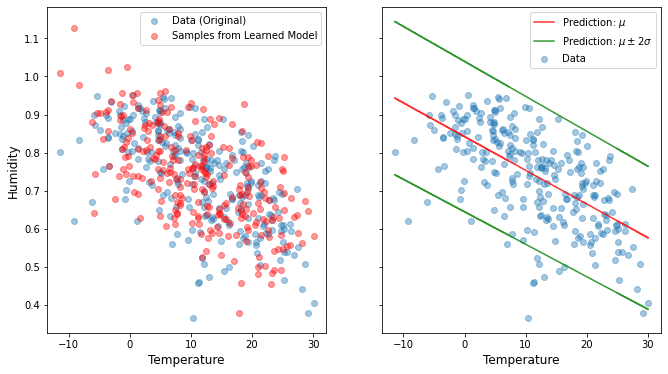

In [ ]:
y_model = prob_lin_model_2(X_test_scaled)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), sharey=True)
ax1.scatter(X_test, y_test, alpha=0.4, label='Data (Original)')
ax1.scatter(X_test, y_sample, alpha=0.4, color='red', label='Samples from Learned Model')
ax1.set_xlabel('Temperature', fontsize=12)
ax1.set_ylabel('Humidity', fontsize=12)
ax1.legend()
ax2.scatter(X_test, y_test, alpha=0.4, label='Data')
ax2.plot(X_test, y_hat, color='red', alpha=0.8, label='Prediction: $\mu$')
ax2.plot(X_test, y_hat_m2sd, color='green', alpha=0.8, label='Prediction: $\mu \pm 2 \sigma$')
ax2.plot(X_test, y_hat_p2sd, color='green', alpha=0.8)
ax2.set_xlabel('Temperature', fontsize=12)
ax2.legend()
plt.savefig(path_to_file + '/TensorFlow_AdvancedSp./TensorFlow_Prob/Temp_Humid_LinReg_Mean_Var.png', dpi=200)
plt.show()

In [ ]:
#### check for a single sample

print (X_test_scaled.shape, X_test_scaled[5])

y_model_5 = prob_lin_model_2(X_test_scaled[5])
print (y_model_5.mean(), y_model_5.stddev())
print (type(y_model_5.mean().numpy()))
y_model_5_mean = y_model_5.mean().numpy()
y_model_5_std = y_model_5.stddev().numpy()
print (len(y_sample), y_model_5_mean[0], y_model_5_std[0])

(268, 1) [-1.38897598]
tf.Tensor([[0.84907365]], shape=(1, 1), dtype=float32) tf.Tensor([[0.09758864]], shape=(1, 1), dtype=float32)
<class 'numpy.ndarray'>
268 [0.84907365] [0.09758864]


In [ ]:
print (y_sample[150:160])

tf.Tensor(
[[0.6487317 ]
 [0.6501459 ]
 [0.70137334]
 [0.7254443 ]
 [0.85489154]
 [0.9348712 ]
 [0.88236076]
 [0.9105178 ]
 [0.6059127 ]
 [0.7630727 ]], shape=(10, 1), dtype=float32)


#### Non-Linear _Probabilistic Model_

In the Dense layer instead of linear activation, we use non-linear activation function like 'sigmoid' to build a non-linear probabilistic model (with addition of Independent Normal Layer). 

In [ ]:
#### try a non-linear model 

non_lin_model = tf.keras.models.Sequential([tf.keras.layers.Dense(input_shape=(1,), units=2, activation='sigmoid'), # non-linear part
                                            tf.keras.layers.Dense(tfpl.IndependentNormal.params_size(event_shape=1)), 
                                            tfpl.IndependentNormal(event_shape=1)
                                            ])
non_lin_model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005))
non_lin_model.summary()

# dense layer num params 
# output channel (2, mean and variance) * (input channel + 1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 2)                 4         
                                                                 
 dense_6 (Dense)             (None, 2)                 6         
                                                                 
 independent_normal_2 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [ ]:
non_lin_model.fit(X_train_scaled, y_train, epochs=500, verbose=False)
non_lin_model.evaluate(X_test_scaled, y_test)

9/9 [==============================] - 0s 2ms/step - loss: -0.9153


-0.9152969717979431

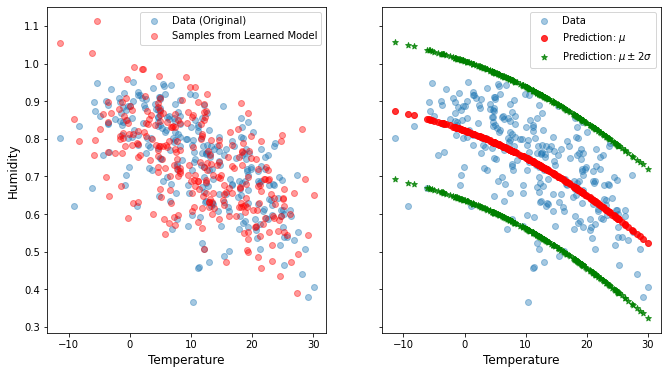

In [ ]:
y_model = non_lin_model(X_test_scaled)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_low2sd = y_hat - 2 * y_sd
y_hat_high2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), sharey=True)
ax1.scatter(X_test, y_test, alpha=0.4, label='Data (Original)')
ax1.scatter(X_test, y_sample, alpha=0.4, color='red', label='Samples from Learned Model')
ax1.set_xlabel('Temperature', fontsize=12)
ax1.set_ylabel('Humidity', fontsize=12)
ax1.legend()
ax2.scatter(X_test, y_test, alpha=0.4, label='Data')
ax2.scatter(X_test, y_hat, color='red', alpha=0.8, label='Prediction: $\mu$')
ax2.scatter(X_test, y_hat_low2sd, color='green', alpha=0.8, label='Prediction: $\mu \pm 2 \sigma$', marker='*')
ax2.scatter(X_test, y_hat_high2sd, color='green', alpha=0.8, marker='*')
ax2.set_xlabel('Temperature', fontsize=12)
ax2.legend()
plt.savefig(path_to_file + '/TensorFlow_AdvancedSp./TensorFlow_Prob/Temp_Humid_nonLinReg_Mean_Var.png', dpi=200)
plt.show()

Plots above are for understanding aleatoric uncertainty. If we don't have the uncertainty information, prediction for humidity for a given temperature is equivalent to point estimate. 

With a generic linear regression will give us a value of humidity for a given temperature which most probably won't be the exact value and that's why uncertainty info helps us to understand the noisy data behaviour. 


------------------------------------------------------
------------------------------------------------------

## **Uncertainties in Weights of the Model (Epistemic Uncertainty)**

So far we tried to model the general stochasticity of the data, the underlying noise by adding some distribution at the last layer of the model i.e. the final prediction is a random variable. 

Epistemic uncertainty captures the uncertainties in the model parameters of the DNN. Likely set of parameter values given some datapoints, can be represented as a distribution (posterior distribution) i.e. which parameters values are more likely given the data the network has seen. So we start with some prior distribution of the weights and update them to obtain posterior distribution.  

Consider a Bayesian linear regression on $x_i$ and $y_i$ with $i=1, \ldots, n$ and a unit Gaussian prior on both $\alpha$ and $\beta$:

$$
y_i = \alpha + \beta x_i + \epsilon_i, \quad 
\epsilon_i \sim N(0, \sigma^2), \quad 
\alpha \sim N(0, 1), \quad 
\beta \sim N(0, 1)
$$


For a multivariate normal distribution it is possible to get the exact form of the posterior.
In general, it's not possible to determine the analytical form for the posterior.  For example, in models with a hidden layer with nonlinear activation function, the analytical posterior cannot be determined in general, and variational methods as below are useful.

### Weight Uncertainties: Bayes by Backprop

The main idea of the variational posterior can be found in this paper '[Weight Uncertainties in Neural Netowrk](https://arxiv.org/pdf/1505.05424.pdf)'.  

Bayesian inference for neural networks calculates the posterior distribution of the weights given the training data, $P(w|D)$. _Variational Bayes_ methods approximate the posterior distribution with a second function, called a _variational posterior_. This function has a known functional form, and hence avoids the need to determine the posterior $𝑃(𝑤|𝐷)$ exactly. There are some risks in this approach, because the approximation may be very bad, leading to a posterior that is highly inaccurate. In order to mediate this, the variational posterior usually has a number of parameters, denoted by $\theta$, that are tuned so that the function approximates the posterior as well as possible. 
Variational learning finds the parameters $\theta$ of a distribution on the
weights $q(w|θ)$ that minimises the Kullback-Leibler (KL) divergence with the true Bayesian posterior on the weights. 

$$\theta^{*}  = \text{arg}\, \underset{\theta}{\text{min}}\,  \mathrm{KL}\, [q(w|\theta)||P (w|D)]\, ...... \, (1)$$


where the definition of KL  divergence is:

$$KL(p_1|| p_2) = \sum \limits_{i=1}^n\, p_1\, \cdot \text{log}\,\left[\frac{p_1}{p_2}\right] = \mathbb{E}_{p_1}\, \left[\text{log}\, \frac{p_1}{p_2}\right]$$

Using the definition of KL divergence we can reduce Eq. 1 as below: 

(We kind of described similar steps to introduce [EM algorithm before](https://github.com/suvoooo/Machine_Learning/blob/master/ExMax_ALgo/LVM.ipynb), also you can check the original paper for more). 

$$
\begin{align}
KL\, (q(w | \theta) || P(w | D)) &= \int q(w | \theta) \log \left( \frac{q(w | \theta)}{P(w | D)} \right) \text{d} w \\
&= \int q(w | \theta) \log \left( \frac{q(w | \theta) P(D)}{P(D | w) P(w)} \right) \text{d} w \\
&= \int q(w | \theta) \log P(D) \text{d} w + \int q(w | \theta) \log \left( \frac{q(w | \theta)}{P(w)} \right) \text{d} w - \int q(w | \theta) \log P(D | w) \text{d} w \\
&= \log P(D) + KL\, ( q(w | \theta) || P(w) ) - \mathbb{E}_{q(w | \theta)}(\log P(D | w))
\end{align}
$$

where, in the last line, we have used $\int q(w | \theta)\, \log P(D) \text{d}w = \log \, P(D) \int q(w | \theta) \text{d} w = \log P(D)$; 

Since $q(w | \theta)$ is a probability distribution and hence integrates to $1$. If we consider the data $D$ to be constant, the first term is a constant also, and we may ignore it when minimising the above. We are left with the function

$$
L(\theta | D) = KL\, ( q(w | \theta) || P(w) ) - \mathbb{E}_{q(w | \theta)}(\log P(D | w))\, ......\, (2)
$$

We combine this $L(\theta | D)$ with the previous integration results: 

$$
\begin{align} 
&KL\, (q(w | \theta) || P(w | D)) = \log \, P(D) + L(\theta | D)\\
&\implies \log\, P(D) \geq - L(\theta | D)\, ;\, \text{KL Divergence}\geq 0  
\end{align}
$$

The cost function in Eq. (2) is a sum of:
1. Data-dependent part, which the authors referred to as the _likelihood cost_. This implies that the variational posterior parameters should maximise the expectation of the log-likelihood $\text{log}\, P(𝐷|𝑤)$, meaning the model assigns a high likelihood to the data.

2. Prior-dependent part, which the authors referred to as the _complexity cost_. The KL divergence between $q(w | \theta), P(w)$ implies that the variational posterior shouldn't be too different to the prior.  

**$- L(\theta | D)\,$ is also famously called Evidence Lower-Bound, i.e. it puts a lower bound on the log-evidence (Data).**

The way we minimize the loss function is via re-parametrization trick. 

Later on we will use [`DenseVariational` layer](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseVariational) for implementing a variational posterior. 

In [ ]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.models.Sequential([tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), 
                                                                                                           scale_diag=tf.ones(n)))]) 
    # lambda parameter t is not used in the Multivariate Distribution
    return prior_model

In [ ]:
# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_s, bias_s, dtype=None):
    n = kernel_s + bias_s
    post_model = tf.keras.models.Sequential([tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype), 
                                             tfpl.MultivariateNormalTriL(n)])
    return post_model

In [ ]:
# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution

model_epist = tf.keras.models.Sequential([tfpl.DenseVariational(units=1, input_shape=(1, ), make_prior_fn=prior, 
                                                                make_posterior_fn=posterior, 
                                                                kl_weight=1/X_train.shape[0], 
                                                                kl_use_exact=True)])

model_epist.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.003))
model_epist.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVar  (None, 1)                5         
 iational)                                                       
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


There's a subtle reason for using `kl_weight = 1/X_train.shape[0]` . 

Our objective is to maximize the ELBO & variational learning finds the parameters $\theta$ of a distribution on the weights $q(w|θ)$ that minimises the Kullback-Leibler (KL) divergence with the true Bayesian posterior on the weights. The $\theta$'s at this stage can be thought of as means and variances of the normal distribution. Referring back to Eq. 2 ELBO is given by two terms --

$$
-L(\theta | D) = - KL\, ( q(w | \theta) || P(w) ) + \mathbb{E}_{q(w | \theta)}(\log P(D | w))\, ......\, (3)
$$

Assuming i.i.d. data 

$$
-L(\theta | D) = - KL\, ( q(w | \theta) || P(w) ) + \sum_i \mathbb{E}_{q(w | \theta)}(\log P(D_i | w))\, ......\, (4)
$$

While training we optimize the $L(\theta|D)$ i.e. ELBO using mini-batches. This means we compute a partial sum over the full dataset. 

$$
- KL\, ( q(w | \theta) || P(w) ) + \frac{N}{B}\, \sum_j \mathbb{E}_{q(w | \theta)}(\log P(D_j | w))\, ......\, (5)
$$

where $N$ is the size of the dataset i.e `X_train.shape[0]` and $B$ is the mini-batch size. 

Per sample loss: 

$$
- \frac{1}{N}\, KL\, ( q(w | \theta) || P(w) ) + \frac{1}{B}\, \sum_j \mathbb{E}_{q(w | \theta)}(\log P(D_j | w))\, ......\, (6)
$$



In [ ]:
model_epist.fit(X_train_scaled, y_train, epochs=800, verbose=False)

# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]]) # prior weight
model_prior = model_epist.layers[0]._prior(dummy_input)
model_posterior = model_epist.layers[0]._posterior(dummy_input)

print('prior mean:           ', model_prior.mean().numpy(),  '\n')

print('prior variance:       ', model_prior.variance().numpy(),  '\n')

print('posterior mean:       ', model_posterior.mean().numpy())

print('posterior covariance: ', model_posterior.covariance().numpy()[0], '\n')

print('                      ', model_posterior.covariance().numpy()[1])

prior mean:            [0. 0.] 

prior variance:        [1. 1.] 

posterior mean:        [-0.08459467  0.7352085 ]
posterior covariance:  [5.178126e-04 5.294128e-05] 

                       [5.294128e-05 5.332800e-04]


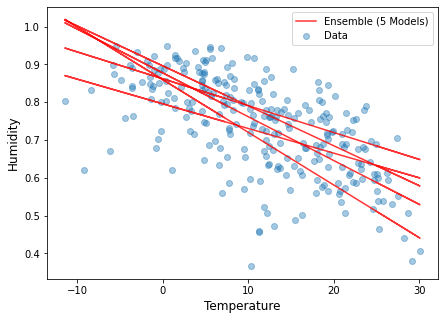

In [ ]:
# Plot an ensemble of linear regressions, with weights sampled from
# the posterior distribution

fig = plt.figure(figsize=(7, 5))
plt.scatter(X_test, y_test, alpha=0.4, label='Data')

for _ in range(5):
    y_model = model_epist(X_test_scaled)
    if _ == 0:
        plt.plot(X_test, y_model, color='red', alpha=0.8, label='Ensemble (5 Models)')
    else:
        plt.plot(X_test, y_model, color='red', alpha=0.8)        
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Humidity', fontsize=12)        
plt.legend()
plt.savefig(path_to_file + '/TensorFlow_AdvancedSp./TensorFlow_Prob/Temp_Humid_LinReg_Epistemic.png', dpi=200)
plt.show()

What these lines represent: ensemble of 5 lines according to our posterior distribution that could have generated the data. 

## **Uncertainties Inherent in the Data + Weights of the Model (Epistemic + Aleatoric Uncertainties)**

In [ ]:
# Create probabilistic regression with one hidden layer, weight (epistemic) uncertainty + aleatoric uncertainty

model_non_lin_al_ep = tf.keras.models.Sequential([tfpl.DenseVariational(units=1, input_shape=(1,), make_prior_fn=prior, 
                                                                        make_posterior_fn=posterior, 
                                                                        kl_weight=1/X_train.shape[0], activation='tanh'), 
                                                  tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1), make_prior_fn=prior, 
                                                                        make_posterior_fn=posterior, 
                                                                        kl_weight=1/X_train.shape[0]), 
                                                  tfpl.IndependentNormal(1)])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_non_lin_al_ep.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.002))
model_non_lin_al_ep.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_1 (DenseV  (None, 1)                5         
 ariational)                                                     
                                                                 
 dense_variational_2 (DenseV  (None, 2)                14        
 ariational)                                                     
                                                                 
 independent_normal_3 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


**Calculation of Number of Parameters:** 

Second layer has 14 parameters. We have 1 input & 2 output, so: $1\times 2$ weights + $2$ biases $= 4$ parameters. 
Then we have a lower triangular matrix for the covariance: So $(4\times 3)/2 + 4 = 10$ and every parameter has their own mean, i.e. $10 + 4 = 14$. 

Similarly, for the first layer, we have 1 input and 1 output. So $1\times 1$ weights + $1$ biases $= 2$ parameters. For the lower Tril. matrix we have $(2\times 1)/2 + 2 = 3$. So total parameter $ = 3 + 2 = 5$.  

--------------------------------------------------------

**Notes on `kl_weight` Parameter**: 





In [ ]:
model_non_lin_al_ep.fit(X_train_scaled, y_train, epochs=1000, verbose=False)
model_non_lin_al_ep.evaluate(X_test_scaled, y_test)

9/9 [==============================] - 1s 2ms/step - loss: -0.8863


-0.8862813711166382

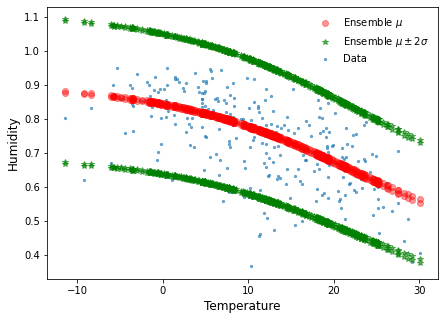

check sample size:  268
check max min of mu + 2\sigma:  tf.Tensor([1.0867273], shape=(1,), dtype=float32) tf.Tensor([0.7281674], shape=(1,), dtype=float32)


In [ ]:
# X_train_scaled = scaler.transform(X_train_re)
# X_test_scaled = scaler.transform(X_test_re)
# inversed_X_test = scaler.inverse_transform(X_test_scaled)

fig = plt.figure(figsize=(7, 5))
plt.scatter(X_test, y_test, marker='.', alpha=0.6, label='Data', s=20)
for _ in range(2):
    y_model = model_non_lin_al_ep(X_test_scaled)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(X_test, y_hat,  color='red', alpha=0.4, label='Ensemble $\mu$', linestyle='none', marker='o', )
        plt.plot(X_test, y_hat_m2sd, color='green', alpha=0.6, label='Ensemble $\mu \pm 2 \sigma$', linestyle='None', marker='*')
        plt.plot(X_test, y_hat_p2sd, color='green', alpha=0.6, linestyle='None', marker='*')
    else:
        plt.plot(X_test, y_hat, color='red', alpha=0.4, linestyle='none', marker='o',)
        plt.plot(X_test, y_hat_m2sd, color='green', alpha=0.6, linestyle='None', marker='*')
        plt.plot(X_test, y_hat_p2sd, color='green', alpha=0.6, linestyle='None', marker='*')
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Humidity', fontsize=12)
plt.legend(framealpha=0)
plt.savefig(path_to_file + '/TensorFlow_AdvancedSp./TensorFlow_Prob/Temp_Humid_nonLinReg_AL_Epi.png', dpi=200)
plt.show()

print ('check sample size: ', len(y_hat))
print ('check max min of mu + 2\sigma: ', max(y_hat_p2sd), min(y_hat_p2sd))